In [1]:
%matplotlib inline


# Out-of-core classification of text documents

This is an example showing how scikit-learn can be used for classification
using an out-of-core approach: learning from data that doesn't fit into main
memory. We make use of an online classifier, i.e., one that supports the
partial_fit method, that will be fed with batches of examples. To guarantee
that the features space remains the same over time we leverage a
HashingVectorizer that will project each example into the same feature space.
This is especially useful in the case of text classification where new
features (words) may appear in each batch.


In [2]:
# Authors: Eustache Diemert <eustache@diemert.fr>
#          @FedericoV <https://github.com/FedericoV/>
# License: BSD 3 clause

from glob import glob
import itertools
import os.path
import re
import tarfile
import time
import sys

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

from html.parser import HTMLParser
from urllib.request import urlretrieve
from sklearn.datasets import get_data_home
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import MultinomialNB


def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return "__file__" in globals()

## Reuters Dataset related routines

The dataset used in this example is Reuters-21578 as provided by the UCI ML
repository. It will be automatically downloaded and uncompressed on first
run.



In [6]:
class ReutersParser(HTMLParser):
    """Utility class to parse a SGML file and yield documents one at a time."""

    def __init__(self, encoding="latin-1"):
        HTMLParser.__init__(self)
        self._reset()
        self.encoding = encoding

    def handle_starttag(self, tag, attrs):
        method = "start_" + tag
        getattr(self, method, lambda x: None)(attrs)

    def handle_endtag(self, tag):
        method = "end_" + tag
        getattr(self, method, lambda: None)()

    def _reset(self):
        self.in_title = 0
        self.in_body = 0
        self.in_topics = 0
        self.in_topic_d = 0
        self.title = ""
        self.body = ""
        self.topics = []
        self.topic_d = ""

    def parse(self, fd):
        self.docs = []
        for chunk in fd:
            self.feed(chunk.decode(self.encoding))
            for doc in self.docs:
                yield doc
            self.docs = []
        self.close()

    def handle_data(self, data):
        if self.in_body:
            self.body += data
        elif self.in_title:
            self.title += data
        elif self.in_topic_d:
            self.topic_d += data

    def start_reuters(self, attributes):
        pass

    def end_reuters(self):
        self.body = re.sub(r"\s+", r" ", self.body)
        self.docs.append(
            {"title": self.title, "body": self.body, "topics": self.topics}
        )
        self._reset()

    def start_title(self, attributes):
        self.in_title = 1

    def end_title(self):
        self.in_title = 0

    def start_body(self, attributes):
        self.in_body = 1

    def end_body(self):
        self.in_body = 0

    def start_topics(self, attributes):
        self.in_topics = 1

    def end_topics(self):
        self.in_topics = 0

    def start_d(self, attributes):
        self.in_topic_d = 1

    def end_d(self):
        self.in_topic_d = 0
        self.topics.append(self.topic_d)
        self.topic_d = ""


def stream_reuters_documents(data_path=None):
    """Iterate over documents of the Reuters dataset.

    The Reuters archive will automatically be downloaded and uncompressed if
    the `data_path` directory does not exist.

    Documents are represented as dictionaries with 'body' (str),
    'title' (str), 'topics' (list(str)) keys.

    """

    DOWNLOAD_URL = (
        "http://archive.ics.uci.edu/ml/machine-learning-databases/"
        "reuters21578-mld/reuters21578.tar.gz"
    )
    ARCHIVE_FILENAME = "reuters21578.tar.gz"

    if data_path is None:
        data_path = os.path.join(get_data_home(), "reuters")
    if not os.path.exists(data_path):
        """Download the dataset."""
        print("downloading dataset (once and for all) into %s" % data_path)
        os.mkdir(data_path)

        def progress(blocknum, bs, size):
            total_sz_mb = "%.2f MB" % (size / 1e6)
            current_sz_mb = "%.2f MB" % ((blocknum * bs) / 1e6)
            if _not_in_sphinx():
                sys.stdout.write("\rdownloaded %s / %s" % (current_sz_mb, total_sz_mb))

        archive_path = os.path.join(data_path, ARCHIVE_FILENAME)
        urlretrieve(DOWNLOAD_URL, filename=archive_path, reporthook=progress)
        if _not_in_sphinx():
            sys.stdout.write("\r")
        print("untarring Reuters dataset...")
        tarfile.open(archive_path, "r:gz").extractall(data_path)
        print("done.")

    parser = ReutersParser()
    for filename in glob(os.path.join(data_path, "*.sgm")):
        for doc in parser.parse(open(filename, "rb")):
            yield doc

## Main

Create the vectorizer and limit the number of features to a reasonable
maximum



In [8]:
vectorizer = HashingVectorizer(
    decode_error="ignore", n_features=2**18, alternate_sign=False
)


# Iterator over parsed Reuters SGML files.
data_stream = stream_reuters_documents()

# We learn a binary classification between the "acq" class and all the others.
# "acq" was chosen as it is more or less evenly distributed in the Reuters
# files. For other datasets, one should take care of creating a test set with
# a realistic portion of positive instances.
all_classes = np.array([0, 1])
positive_class = "acq"

# Here are some classifiers that support the `partial_fit` method
partial_fit_classifiers = {
    "SGD": SGDClassifier(max_iter=5),
    "Perceptron": Perceptron(),
    "NB Multinomial": MultinomialNB(alpha=0.01),
    "Passive-Aggressive": PassiveAggressiveClassifier(),
}


def get_minibatch(doc_iter, size, pos_class=positive_class):
    """Extract a minibatch of examples, return a tuple X_text, y.

    Note: size is before excluding invalid docs with no topics assigned.

    """
    data = [
        ("{title}\n\n{body}".format(**doc), pos_class in doc["topics"])
        for doc in itertools.islice(doc_iter, size)
        if doc["topics"]
    ]
    if not len(data):
        return np.asarray([], dtype=int), np.asarray([], dtype=int)
    X_text, y = zip(*data)
    return X_text, np.asarray(y, dtype=int)


def iter_minibatches(doc_iter, minibatch_size):
    """Generator of minibatches."""
    X_text, y = get_minibatch(doc_iter, minibatch_size)
    while len(X_text):
        yield X_text, y
        X_text, y = get_minibatch(doc_iter, minibatch_size)


# test data statistics
test_stats = {"n_test": 0, "n_test_pos": 0}

# First we hold out a number of examples to estimate accuracy
n_test_documents = 1000
tick = time.time()
X_test_text, y_test = get_minibatch(data_stream, 1000)
parsing_time = time.time() - tick
tick = time.time()
X_test = vectorizer.transform(X_test_text)
vectorizing_time = time.time() - tick
test_stats["n_test"] += len(y_test)
test_stats["n_test_pos"] += sum(y_test)
print("Test set is %d documents (%d positive)" % (len(y_test), sum(y_test)))


def progress(cls_name, stats):
    """Report progress information, return a string."""
    duration = time.time() - stats["t0"]
    s = "%20s classifier : \t" % cls_name
    s += "%(n_train)6d train docs (%(n_train_pos)6d positive) " % stats
    s += "%(n_test)6d test docs (%(n_test_pos)6d positive) " % test_stats
    s += "accuracy: %(accuracy).3f " % stats
    s += "in %.2fs (%5d docs/s)" % (duration, stats["n_train"] / duration)
    return s


cls_stats = {}

for cls_name in partial_fit_classifiers:
    stats = {
        "n_train": 0,
        "n_train_pos": 0,
        "accuracy": 0.0,
        "accuracy_history": [(0, 0)],
        "t0": time.time(),
        "runtime_history": [(0, 0)],
        "total_fit_time": 0.0,
    }
    cls_stats[cls_name] = stats

get_minibatch(data_stream, n_test_documents)
# Discard test set

# We will feed the classifier with mini-batches of 1000 documents; this means
# we have at most 1000 docs in memory at any time.  The smaller the document
# batch, the bigger the relative overhead of the partial fit methods.
minibatch_size = 1000

# Create the data_stream that parses Reuters SGML files and iterates on
# documents as a stream.
minibatch_iterators = iter_minibatches(data_stream, minibatch_size)
total_vect_time = 0.0

# Main loop : iterate on mini-batches of examples
for i, (X_train_text, y_train) in enumerate(minibatch_iterators):

    tick = time.time()
    X_train = vectorizer.transform(X_train_text)
    total_vect_time += time.time() - tick

    for cls_name, cls in partial_fit_classifiers.items():
        tick = time.time()
        # update estimator with examples in the current mini-batch
        cls.partial_fit(X_train, y_train, classes=all_classes)

        # accumulate test accuracy stats
        cls_stats[cls_name]["total_fit_time"] += time.time() - tick
        cls_stats[cls_name]["n_train"] += X_train.shape[0]
        cls_stats[cls_name]["n_train_pos"] += sum(y_train)
        tick = time.time()
        cls_stats[cls_name]["accuracy"] = cls.score(X_test, y_test)
        cls_stats[cls_name]["prediction_time"] = time.time() - tick
        acc_history = (cls_stats[cls_name]["accuracy"], cls_stats[cls_name]["n_train"])
        cls_stats[cls_name]["accuracy_history"].append(acc_history)
        run_history = (
            cls_stats[cls_name]["accuracy"],
            total_vect_time + cls_stats[cls_name]["total_fit_time"],
        )
        cls_stats[cls_name]["runtime_history"].append(run_history)

        if i % 3 == 0:
            print(progress(cls_name, cls_stats[cls_name]))
    if i % 3 == 0:
        print("\n")

Test set is 962 documents (132 positive)
                 SGD classifier : 	   966 train docs (    88 positive)    962 test docs (   132 positive) accuracy: 0.916 in 0.85s ( 1134 docs/s)
          Perceptron classifier : 	   966 train docs (    88 positive)    962 test docs (   132 positive) accuracy: 0.887 in 0.86s ( 1126 docs/s)
      NB Multinomial classifier : 	   966 train docs (    88 positive)    962 test docs (   132 positive) accuracy: 0.863 in 0.89s ( 1084 docs/s)
  Passive-Aggressive classifier : 	   966 train docs (    88 positive)    962 test docs (   132 positive) accuracy: 0.880 in 0.90s ( 1077 docs/s)


                 SGD classifier : 	  3299 train docs (   360 positive)    962 test docs (   132 positive) accuracy: 0.942 in 2.52s ( 1310 docs/s)
          Perceptron classifier : 	  3299 train docs (   360 positive)    962 test docs (   132 positive) accuracy: 0.949 in 2.52s ( 1307 docs/s)
      NB Multinomial classifier : 	  3299 train docs (   360 positive)    962 tes

## Plot results

The plot represents the learning curve of the classifier: the evolution
of classification accuracy over the course of the mini-batches. Accuracy is
measured on the first 1000 samples, held out as a validation set.

To limit the memory consumption, we queue examples up to a fixed amount
before feeding them to the learner.



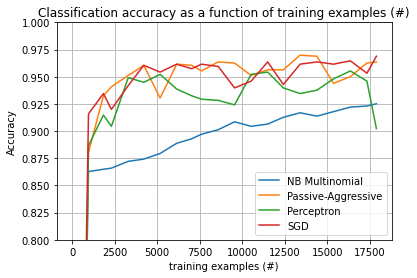

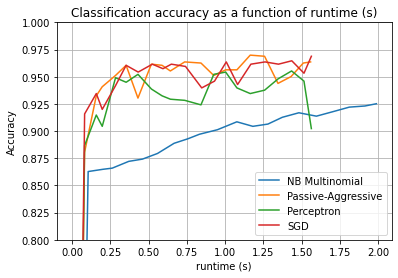

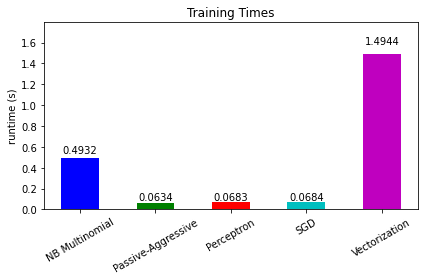

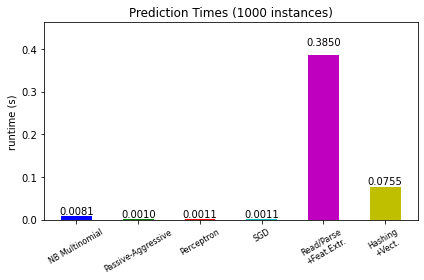

In [9]:
def plot_accuracy(x, y, x_legend):
    """Plot accuracy as a function of x."""
    x = np.array(x)
    y = np.array(y)
    plt.title("Classification accuracy as a function of %s" % x_legend)
    plt.xlabel("%s" % x_legend)
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.plot(x, y)


rcParams["legend.fontsize"] = 10
cls_names = list(sorted(cls_stats.keys()))

# Plot accuracy evolution
plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with #examples
    accuracy, n_examples = zip(*stats["accuracy_history"])
    plot_accuracy(n_examples, accuracy, "training examples (#)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc="best")

plt.figure()
for _, stats in sorted(cls_stats.items()):
    # Plot accuracy evolution with runtime
    accuracy, runtime = zip(*stats["runtime_history"])
    plot_accuracy(runtime, accuracy, "runtime (s)")
    ax = plt.gca()
    ax.set_ylim((0.8, 1))
plt.legend(cls_names, loc="best")

# Plot fitting times
plt.figure()
fig = plt.gcf()
cls_runtime = [stats["total_fit_time"] for cls_name, stats in sorted(cls_stats.items())]

cls_runtime.append(total_vect_time)
cls_names.append("Vectorization")
bar_colors = ["b", "g", "r", "c", "m", "y"]

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5, color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=10)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel("runtime (s)")
ax.set_title("Training Times")


def autolabel(rectangles):
    """attach some text vi autolabel on rectangles."""
    for rect in rectangles:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2.0,
            1.05 * height,
            "%.4f" % height,
            ha="center",
            va="bottom",
        )
        plt.setp(plt.xticks()[1], rotation=30)


autolabel(rectangles)
plt.tight_layout()
plt.show()

# Plot prediction times
plt.figure()
cls_runtime = []
cls_names = list(sorted(cls_stats.keys()))
for cls_name, stats in sorted(cls_stats.items()):
    cls_runtime.append(stats["prediction_time"])
cls_runtime.append(parsing_time)
cls_names.append("Read/Parse\n+Feat.Extr.")
cls_runtime.append(vectorizing_time)
cls_names.append("Hashing\n+Vect.")

ax = plt.subplot(111)
rectangles = plt.bar(range(len(cls_names)), cls_runtime, width=0.5, color=bar_colors)

ax.set_xticks(np.linspace(0, len(cls_names) - 1, len(cls_names)))
ax.set_xticklabels(cls_names, fontsize=8)
plt.setp(plt.xticks()[1], rotation=30)
ymax = max(cls_runtime) * 1.2
ax.set_ylim((0, ymax))
ax.set_ylabel("runtime (s)")
ax.set_title("Prediction Times (%d instances)" % n_test_documents)
autolabel(rectangles)
plt.tight_layout()
plt.show()